<a href="https://colab.research.google.com/github/maciej-zieniewicz/omdena-malaria/blob/master/Satellite_Image_Processing_Demonstrator_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstrator on Satellite Image Processing with Deep Learning
### kudos to Frank :)

and Dr. Tristan Behrens
https://colab.research.google.com/drive/1tGgypw1qM6TJD9A2NLWI_X1JMoyiuC_b?usp=sharing#scrollTo=fTHVeq90-0ek

In this notebook we will:
- make use the tensorflow Eurosat data set, which is based on Sentinel-2 data 
- we use the rgb bands only as provided in the training data from Zzapp, but there is a dataset with all 13 bands avaiable as well (see description after the download)
- train a Convolutional Neural Network for this task,
- decrease overfitting with dropout,
- decrease overfitting even further with data augmentation, and
- apply transfer learning.


#### Make sure that we have TensorFlow 2 enabled.

In [1]:
%tensorflow_version 2.x

#### Import all necessary modules  and check TensorFlow version.

In [2]:
import tensorflow as tf
assert tf.__version__.startswith("2."), "You have TensorFlow version {}, 2.X is required, please upgrade.".format(tf.__version__)

import tensorflow_datasets as tfds
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

#### Define global parameters

In [3]:
histories = {}
epochs = 100
batch_size = 256

### Load and split EuroSAT-dataset.

Data split ibto three subsets:
- Train: For training the Neural Network.
- Validate: To see how good the Neural Network is after each epoch.
- Test: To see how good the Neural Network is after training.

Link: [EuroSAT](https://github.com/phelber/eurosat).

In [4]:
(dataset_train_original, dataset_validate_original, dataset_test_original), info = tfds.load(
    name="eurosat/rgb", 
    split=["train[:70%]", "train[70%:90%]", "train[90%:]"],
    with_info=True,
    as_supervised=True
)
print(info)
print("Number of training sets:   ", len(list(dataset_train_original)))
print("Number of validation sets:", len(list(dataset_validate_original)))
print("Number of testing sets:    ", len(list(dataset_test_original)))

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat
',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
     

## Data Exploration
Look at random examples of the 64x64 px image including their classes

In [5]:
# The class names can be found in the above mentioned github repository
class_names = ["annual crop", "forest", "herbaceous vegetation", "highway", "industrial", "pasture", "permanent crop", "residential", "river", "sea & lake"]

def label_to_string(label):
  return class_names[label]

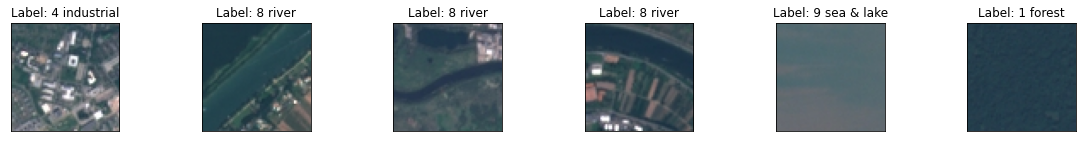

In [6]:
index = 1
plt.figure(figsize=(20, 2))
for dataset_example in dataset_train_original.take(6):
    image, label = dataset_example

    plt.subplot(1, 6, index)
    plt.imshow(image.numpy())
    plt.xticks([])
    plt.yticks([])
    plt.title("Label: {} {}".format(label.numpy(), label_to_string(label.numpy())))
    index += 1
plt.show()
plt.close()

### Preparing the datasets with tf.data.

We will make sure that all images are normalized and that all labels are one-hot-encoded.

Link: [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)




#### Preparing custom datasets
Water containing fields are grouped into class '1', the rest is grouped into class '0'.

In [7]:
def custom_dataset(input_dataset): 

  x, y = [], []
  for example in tqdm(input_dataset, total=len(list(input_dataset))):
    img, label = example
    img = img.numpy()
    str_class_name = class_names[label.numpy()]
    str_class_name ='water' if str_class_name in ['river', 'sea & lake'] else 'no-water'
    label = 1 if str_class_name == 'water' else 0
    x.append(img)
    y.append(label)

  x = np.array(x)
  y = np.array(y)

  print(x.shape, y.shape)
  dataset = tf.data.Dataset.from_tensor_slices((x,y))
  return dataset

dataset_train_original = custom_dataset(dataset_train_original)
dataset_validate_original = custom_dataset(dataset_validate_original)
dataset_test_original = custom_dataset(dataset_test_original)

100%|██████████| 18900/18900 [00:10<00:00, 1760.23it/s]


(18900, 64, 64, 3) (18900,)


100%|██████████| 5400/5400 [00:03<00:00, 1617.34it/s]


(5400, 64, 64, 3) (5400,)


100%|██████████| 2700/2700 [00:01<00:00, 1469.53it/s]

(2700, 64, 64, 3) (2700,)


#### Data Augumentation

In [8]:
def augment(image, label):
    image_augmented = image
    image_augmented = tf.image.random_flip_left_right(image_augmented)
    image_augmented = tf.image.random_flip_up_down(image_augmented)
    image_augmented = tf.image.random_contrast(image_augmented, 0.5, 1.0)
    image_augmented = tf.image.random_brightness(image_augmented, 0.25)
    image_augmented = tf.image.random_hue(image_augmented, 0.2)
    return image_augmented, label

#### Encoding

In [9]:
def custom_encode(image, label):
    image_encoded = tf.image.convert_image_dtype(image, dtype=tf.float32)
    label_encoded = tf.one_hot(label, depth=2)
    return image_encoded, label_encoded

dataset_train = dataset_train_original.map(lambda image, label: custom_encode(image, label)).cache()
dataset_train = dataset_train.map(lambda image, label: augment(image, label))
dataset_validate = dataset_validate_original.map(lambda image, label: custom_encode(image, label)).cache()
dataset_test = dataset_test_original.map(lambda image, label: custom_encode(image, label)).cache()

### CNN model

In [19]:
def build_binary_CNN_model(dropout=True):
  '''
  Build a multi-layer CNN for satellite image classification
  INPUT
  dropout   boolean   if true, dropout layers are included
  OUTPUT
  non-compiled keras model
  '''

  model = models.Sequential()

  # Convolutional block 1
  model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(64, 64, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
  model.add(layers.MaxPooling2D((2, 2)))
  if dropout:
    model.add(layers.Dropout(0.2))

  # Convolutional block 2
  model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
  model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
  model.add(layers.MaxPooling2D((2, 2)))
  if dropout:
    model.add(layers.Dropout(0.3))

  # Convolutional block 3
  model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
  model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
  if dropout:
    model.add(layers.Dropout(0.4))

  # Latent space
  model.add(layers.Flatten())

  # Classifier
  model.add(layers.Dense(128, activation="relu"))
  if dropout:
    model.add(layers.Dropout(0.5))
  model.add(layers.Dense(2, activation="softmax"))

  return model

In [20]:
model_augment_binary = build_binary_CNN_model(dropout=True)

model_augment_binary.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)       

In [21]:
model_augment_binary.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model_augment_binary.fit(
    dataset_train.shuffle(10000).batch(batch_size),
    epochs=epochs,
    validation_data=dataset_validate.batch(batch_size),
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor ='val_loss', patience=7)],
    class_weight= {0: 1, 1: 4}
)

histories["Dropout-Augmentation-Binary"] = history


Epoch 1/100
74/74 [==============================] - 15s 202ms/step - loss: 0.9494 - accuracy: 0.6260 - val_loss: 0.4261 - val_accuracy: 0.7457
Epoch 2/100
74/74 [==============================] - 15s 199ms/step - loss: 0.8482 - accuracy: 0.6731 - val_loss: 0.5920 - val_accuracy: 0.5950
Epoch 3/100
74/74 [==============================] - 15s 197ms/step - loss: 0.8077 - accuracy: 0.6833 - val_loss: 0.4771 - val_accuracy: 0.7287
Epoch 4/100
74/74 [==============================] - 15s 197ms/step - loss: 0.7868 - accuracy: 0.6954 - val_loss: 0.5259 - val_accuracy: 0.6652
Epoch 5/100
74/74 [==============================] - 15s 198ms/step - loss: 0.7449 - accuracy: 0.7135 - val_loss: 0.5432 - val_accuracy: 0.6511
Epoch 6/100
74/74 [==============================] - 15s 196ms/step - loss: 0.7389 - accuracy: 0.7197 - val_loss: 0.4488 - val_accuracy: 0.7391
Epoch 7/100
74/74 [==============================] - 14s 196ms/step - loss: 0.7086 - accuracy: 0.7183 - val_loss: 0.3578 - val_accuracy:

### Plot Learning curve



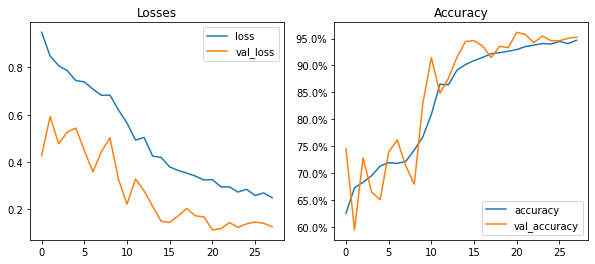

In [22]:
def plot_history(history):
  plt.figure(figsize=(10, 4))

  plt.subplot(1, 2, 1)
  plt.plot(history.history["loss"], label="loss")
  plt.plot(history.history["val_loss"], label="val_loss")
  plt.legend()
  plt.title("Losses")

  ax = plt.subplot(1, 2, 2)
  plt.plot(history.history["accuracy"], label="accuracy")
  plt.plot(history.history["val_accuracy"], label="val_accuracy")
  acc = ax.get_yticks()
  ax.set_yticklabels(['{:,.1%}'.format(y) for y in acc])
  plt.legend()
  plt.title("Accuracy")

  plt.show()
  plt.close()

plot_history(history)

#### How is the model performing on the test set ?

In [23]:
loss, acc = model_augment_binary.evaluate(dataset_test.batch(32), verbose=0)
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc))

Loss: 0.12115214020013809
Accuracy: 0.9574074149131775


## Compare results.

## Evaluation on test set
As Dropout+Augmentation performs best on validation set, let's make an evaluation on the test set using this model

In [24]:

y_test = np.empty(0)
y_pred = np.empty(0)

for dataset_example in tqdm(dataset_test, total=len(list(dataset_test))):
    image, label = dataset_example
    image = np.expand_dims(image, axis=0) 
    prediction = np.argmax(model_augment_binary.predict(image))
    y_test = np.append(y_test, np.argmax(label))
    y_pred = np.append(y_pred, prediction)

100%|██████████| 2700/2700 [01:49<00:00, 24.55it/s]


In [25]:
print("Test accuracy: {}".format((y_test==y_pred).mean()))

Test accuracy: 0.9574074074074074


              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97      2109
         1.0       0.86      0.96      0.91       591

    accuracy                           0.96      2700
   macro avg       0.92      0.96      0.94      2700
weighted avg       0.96      0.96      0.96      2700



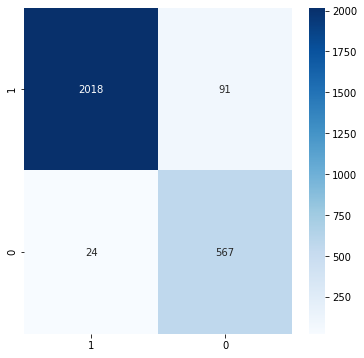

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
from seaborn import heatmap

matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
heatmap(matrix,xticklabels=['1', '0'], yticklabels=['1', '0'], cmap='Blues', annot=True, fmt='.0f');
print(classification_report(y_test, y_pred))